In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import inf

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
colnames=['timestamp', 'game_name', 'num_channels', 'num_viewers']

In [4]:
df=pd.read_csv('Natasha.csv',header =None, names = colnames)

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
df=df.sort_values(by=['game_name','timestamp'])

In [7]:
df.reset_index(inplace = True)

In [8]:
df.drop(columns='index',inplace = True)

# Smart "Diff()" to only find diff if game names are equivalent

In [9]:
#
# df['diff_channels'] = df['num_channels']
# df['diff_viewers'] = df['num_viewers']
# for row_index in range(1,df.shape[0]):
#     # 0 - time_logged
#     # 1 - game_name
#     # 2 - num_channels
#     # 3 - num_viewers
#     # 4 - diff_channels
#     # 5 - diff_viewers
    
    
#     # Check if game_name of this row and previous row are the same
#     if df.iloc[row_index,1] == df.iloc[row_index-1,1]:
#         df.iloc[row_index,4] = int(df.iloc[row_index,2] - df.iloc[row_index-1,2])
#         df.iloc[row_index,5] = int(df.iloc[row_index,3] - df.iloc[row_index-1,3])
#     else:
#     # If the game names are different, the difference between metrics is invalid, fill with NaN
#         df.iloc[row_index,4] = np.NaN
#         df.iloc[row_index,5] = np.NaN

In [10]:
df['diff_channels'] = df['num_channels']
df['diff_viewers'] = df['num_viewers']

In [11]:
df_values =  df.values

In [12]:
df_values[4,1]

' F1 2019'

In [13]:
for row_index in range(1,df.shape[0]):
    # 0 - time_logged
    # 1 - game_name
    # 2 - num_channels
    # 3 - num_viewers
    # 4 - diff_channels
    # 5 - diff_viewers
    
    
    # Check if game_name of this row and previous row are the same
    if df_values[row_index,1] == df_values[row_index-1,1]:
        df_values[row_index,4] = int(df_values[row_index,2] - df_values[row_index-1,2])
        df_values[row_index,5] = int(df_values[row_index,3] - df_values[row_index-1,3])
    else:
    # If the game names are different, the difference between metrics is invalid, fill with NaN
        df_values[row_index,4] = np.NaN
        df_values[row_index,5] = np.NaN

In [14]:
diff_df=pd.DataFrame(df_values).rename(columns={0: 'timestamp',
                                                1: 'game_name',
                                                2: 'num_channels',
                                                3: 'num_viewers',
                                                4: 'diff_channels',
                                                5: 'diff_viewers'})

In [15]:
diff_df.to_pickle('./sully_df_differences.pkl',compression = 'zip')

In [16]:
df=pd.read_pickle('./sully_df_differences.pkl',compression = 'zip')

In [17]:
df.shape

(2092036, 6)

In [21]:
LoL=df.loc[df['game_name'] == 'League of Legends']

In [22]:
LoL.drop(columns = ['timestamp','game_name', 'num_channels','num_viewers'])

,diff_channels,diff_viewers
938390,NaN,NaN
938391,-376,-16775
938392,-83,3915
938393,-14,6393
938394,-201,18045
938395,-216,-10105
938396,-259,330
938397,-227,-19222
938398,-142,3021
938399,49,-736


In [23]:
# timeseries_to_supervised(df)

# Jason Brownlee

LSTM Code

https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/

# Inspired by Tony's Code

In [25]:
LoL.head()

,timestamp,game_name,num_channels,num_viewers,diff_channels,diff_viewers
938390,2019-04-22 00:00:00,League of Legends,3160,97898,NaN,NaN
938391,2019-04-22 01:00:00,League of Legends,2784,81123,-376,-16775
938392,2019-04-22 02:00:00,League of Legends,2701,85038,-83,3915
938393,2019-04-22 03:00:00,League of Legends,2687,91431,-14,6393
938394,2019-04-22 04:00:00,League of Legends,2486,109476,-201,18045


In [170]:
# Necessary to prevent NaN loss function
LoL.dropna(inplace = True)

/anaconda3/envs/twitchrecommender/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [175]:
# pd.DataFrame(train_sample)

In [322]:
def slice_data(train_ratio,data_df, column_name ):
    # Divide into train set by cutting up dataframe using train_len
    true_test_size = 168
    train_len = int(data_df.shape[0] * (train_ratio))
    
    
    # Train data set (index 0 to the training length)
    train = data_df[column_name][1:train_len].copy()
    train.reset_index(inplace=True, drop=True)

    # Validation data set (index of end of training data up to the 'true test')
    test = data_df[column_name][train_len:-true_test_size].copy()
    test.reset_index(inplace=True, drop=True)
    
    # True test data set (index of end of validation dataset to end of entire dataset)
    true_test = data_df[column_name][-true_test_size:].copy()
    true_test.reset_index(inplace=True, drop=True)

    return train, test, true_test

In [ ]:
scaler-MinMaxScaler()

In [30]:
scaler=MinMaxScaler()
diff_data = LoL[['diff_channels','diff_viewers']].values
print(scaler.fit(diff_data))

MinMaxScaler(copy=True, feature_range=(0, 1))


In [31]:
LoL['diff_channels_scaled']=scaler.transform(diff_data)[:,0]
LoL['diff_viewers_scaled']=scaler.transform(diff_data)[:,1]

/anaconda3/envs/twitchrecommender/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/twitchrecommender/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
LoL.head()


,timestamp,game_name,num_channels,num_viewers,diff_channels,diff_viewers,diff_channels_scaled,diff_viewers_scaled
938391,2019-04-22 01:00:00,League of Legends,2784,81123,-376,-16775,0.139108,0.536666
938392,2019-04-22 02:00:00,League of Legends,2701,85038,-83,3915,0.395451,0.570331
938393,2019-04-22 03:00:00,League of Legends,2687,91431,-14,6393,0.455818,0.574362
938394,2019-04-22 04:00:00,League of Legends,2486,109476,-201,18045,0.292213,0.593321
938395,2019-04-22 05:00:00,League of Legends,2270,99371,-216,-10105,0.279090,0.547519


In [306]:
lags

168

In [307]:
look_back

24

In [310]:
len(dataset)-lags-predict_window-look_back

294

In [340]:
def make_variables(dataset, lags, look_back, predict_window):
    ''' dataset = np.matrix
        lags = integer, number of previous rows to include as features for predicting next
        look_back = integer, number of previous MODELS
        predict_window = integer, number of rows to predict ahead
    '''
    num_features = lags+1
    # starting index - Start at a point where we still have int(look_back) number of rows to look back
    start = look_back
    
    # total length - num previous rows to look at - num rows to predict
    
    stop = len(dataset) - lags - predict_window
    print("Stop value(len(dataset) - lags - predict_window: ", stop)
    print("Start value: look_back: ", start)
    lstm_in_X = np.zeros(shape=(stop-start, look_back+1, num_features))
    lstm_in_Y = np.zeros(shape=(stop-start, look_back+1))

    iter_list = [num for num in range(look_back+1)][::-1]
    
    # Generating the features for the model (based on lags and look back)
    for i in range(start, stop):
        for index, j in enumerate(iter_list):
            X = dataset[i-j : i-j+lags+1, -1]
            lstm_in_X[i-start, index] = np.ravel(X)
            Y = dataset[i-j+lags+1, -1]
            lstm_in_Y[i-start, index] = Y
    return lstm_in_X, lstm_in_Y, num_features

In [103]:
test_in_X, test_in_Y,test_features = make_variables(np.matrix(LoL[['diff_channels_scaled']]), lags, look_back,predict_window)

In [153]:
len(test_in_X[0][0])

51

In [141]:
def train_lstm(train, feature_names, lags,
               look_back, predict_window,
               lstm_neurons, dense_layers
               , epochs = 100, batch_size = 10):
    dataset = np.matrix(train[feature_names])
    lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)
    train_X = lstm_in_X
    train_Y = lstm_in_Y
    
    # Inputs travel from one layer to next
    model = Sequential()
    # LSTM layer 
    model.add(LSTM(lstm_neurons, input_shape=(look_back+1, features)))
    # Dropout of 20% to prevent overfitting
    model.add(Dropout(0.2))
    # Add linear stacked modeling layers with dropout 
    for neurons in dense_layers:
        model.add(Dense(neurons))
        model.add(Dropout(0.2))
    
    # For output, we need to output the number of previous models and our current model
    model.add(Dense(look_back+1))
    
    # Choose loss function and optimizer
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(train_X, train_Y,batch_size = batch_size, epochs = epochs, verbose=1)
    
    pred_Y_train = model.predict(train_X)
    # Every look back model is outputting a prediction for the next day, so we look at the LAST one to
    # get the predictions for days that are out of that batch
    predictions = pred_Y_train[:,-1]
    
    actuals = train_Y[:,-1]
    
    print(model.summary())
    
    return model, dataset, train_X, train_Y, predictions, actuals

In [337]:
def test_lstm(test_df, feature_names, model, predict_window = predict_window): 
    dataset = np.matrix(test_df[feature_names])
    print('Lenght of dataset: ', len(dataset))
    lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)
    pred_Y_train = model.predict(lstm_in_X)
    # Every look back model is outputting a prediction for the next day, so we look at the LAST one to
    # get the predictions for days that are out of that batch
    predictions = pred_Y_train[:,-1]
    actuals = lstm_in_Y[:,-1]
    return predictions, actuals


In [272]:

# Parameters for predict window of 1

train_perc = 0.40
# How many points to look back - 168 = 24 hours/day * 7 days / week 
lags = 50
look_back = 24       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
# List of integers, each corresponding to the number of neurons in N dense layers,
# where N is the number of integers
dense_layers = []
epochs= 1000
batch_size = 10

In [343]:
LoL.shape

(936, 8)

In [344]:
train_sample,test_sample,true_test_sample = slice_data(.4,LoL,['diff_channels'])

In [321]:
test_predictions, test_actuals = test_lstm(test_sample,['diff_channels'],model)

181
-155 24


ValueError: negative dimensions are not allowed

# Prediction of 1 Step for Channel Difference

In [270]:
model, dataset, train_X, train_Y, predictions, actuals = \
train_lstm(train_sample,['diff_channels'],lags, look_back,predict_window,lstm_neurons,dense_layers,epochs,batch_size)

Epoch 1/300
579/579 [==============================] - 10s 18ms/step - loss: 39933.5635
Epoch 2/300
579/579 [==============================] - 3s 6ms/step - loss: 39433.0723
Epoch 3/300
579/579 [==============================] - 4s 6ms/step - loss: 38852.1105
Epoch 4/300
579/579 [==============================] - 4s 7ms/step - loss: 38259.8020
Epoch 5/300
579/579 [==============================] - 4s 6ms/step - loss: 37618.9465
Epoch 6/300
579/579 [==============================] - 4s 6ms/step - loss: 37013.4363
Epoch 7/300
579/579 [==============================] - 4s 6ms/step - loss: 36401.6859
Epoch 8/300
579/579 [==============================] - 3s 6ms/step - loss: 35803.9125
Epoch 9/300
579/579 [==============================] - 4s 6ms/step - loss: 35243.6696
Epoch 10/300
579/579 [==============================] - 4s 6ms/step - loss: 34631.1616
Epoch 11/300
579/579 [==============================] - 3s 6ms/step - loss: 34032.2559
Epoch 12/300
579/579 [============================

579/579 [==============================] - 4s 7ms/step - loss: 13906.5493
Epoch 96/300
579/579 [==============================] - 4s 6ms/step - loss: 13871.6506
Epoch 97/300
579/579 [==============================] - 4s 6ms/step - loss: 13768.2189
Epoch 98/300
579/579 [==============================] - 3s 6ms/step - loss: 13696.5712
Epoch 99/300
579/579 [==============================] - 4s 6ms/step - loss: 13643.0200
Epoch 100/300
579/579 [==============================] - 3s 6ms/step - loss: 13574.8785
Epoch 101/300
579/579 [==============================] - 3s 6ms/step - loss: 13455.2353
Epoch 102/300
579/579 [==============================] - 3s 6ms/step - loss: 13378.4406
Epoch 103/300
579/579 [==============================] - 3s 6ms/step - loss: 13317.3005
Epoch 104/300
579/579 [==============================] - 4s 6ms/step - loss: 13308.4964
Epoch 105/300
579/579 [==============================] - 4s 6ms/step - loss: 13225.9745
Epoch 106/300
579/579 [===========================

KeyboardInterrupt: 

In [215]:
len(predictions)

598

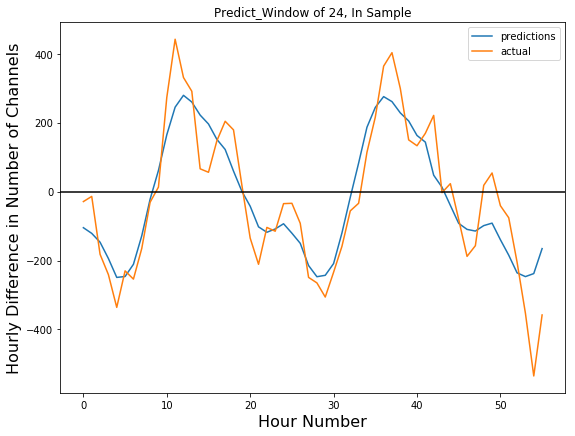

In [261]:
plot_lstm(predictions,actuals,
          'Predict_Window of 1, In Sample',
          'Hour Number',
          'Hourly Difference in Number of Channels',
         lower_lim_index=500)

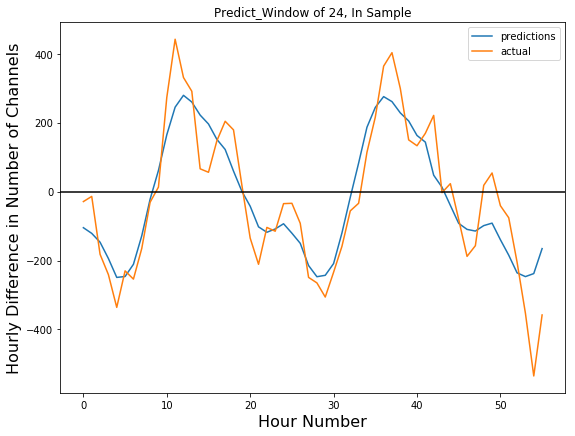

In [263]:
plot_lstm(test_predictions, test_actuals,
          'Predict_Window of 1, Out of Sample',
          'Hour Number',
          'Hourly Difference in Number of Channels',
         lower_lim_index=500)

In [265]:
def rmse(predicted,actuals):
    assert len(predicted) == len(actuals)
    residuals = predicted-actuals
    return np.sqrt(np.sum(np.square(residuals)) / len(residuals))

In [266]:
rmse(predictions,actuals)

80.74147114486877

In [246]:
# model.save('./channel_diff_prediction_lstm')

# Increasing Prediction Window to 168 (1week)

In [273]:

# Parameters for predict window of 1

train_perc = 0.40
# How many points to look back - 168 = 24 hours/day * 7 days / week 
lags = 168
look_back = 24       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 168

# Neural net parameters
lstm_neurons = 128
# List of integers, each corresponding to the number of neurons in N dense layers,
# where N is the number of integers
dense_layers = []
epochs= 1000
batch_size = 10

In [ ]:
day_prediction_model,
day_prediction_dataset,
day_prediction_train_X,
day_prediction_train_Y,
day_predictions,
day_actuals = \
train_lstm(train_sample,['diff_channels'],lags, look_back,24,lstm_neurons,dense_layers,epochs,batch_size)

In [267]:
rmse(day_predictions,day_actuals)

86.37640504808562

In [341]:
day_test_predictions, day_test_actuals =\
test_lstm(test_sample,['diff_channels'],model,predict_window = 24)

Lenght of dataset:  113
Stop value(len(dataset) - lags - predict_window:  -79
Start value: look_back:  24


ValueError: negative dimensions are not allowed

In [269]:
rmse(day_test_predictions,day_test_actuals)

81.96535541894787

In [379]:
teststr=''

In [380]:
if teststr:
    print('yes')
else:
    print('no')

no


In [406]:
def plot_lstm(predictions, actuals,
              title , xlabel ,ylabel,
              lower_lim_index=0,upper_lim_index = len(predictions), saved_fig_name =''):
    lower_lim = lower_lim_index
    upper_lim = upper_lim_index
    fig, ax = plt.subplots(figsize=(8,6))
    # Set background of area behind axis labels
    fig.patch.set_facecolor('white')
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel,fontsize=16)
    plt.tight_layout()
    plt.plot(predictions[lower_lim:upper_lim]);
    plt.plot(actuals[lower_lim:upper_lim]);
    # plt.plot(actuals)
    plt.title(title)
    plt.axhline(y=0, color='black');
    plt.legend(['predictions','actual'])
    if saved_fig_name:
        file_path = './graphs/'+saved_fig_name
        plt.savefig(file_path, dpi=300, bbox_inches = "tight")
        print('saved to : ' + file_path)
    else:
        print('Not Saved')
    plt.show()


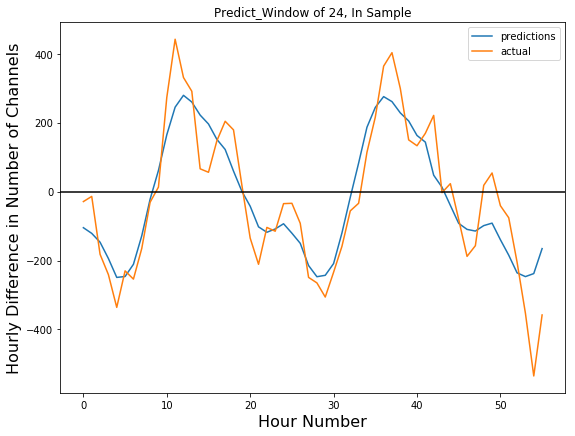

Not Saved


In [400]:
plot_lstm(day_predictions,day_actuals,
          'Predict_Window of 24, In Sample',
          'Hour Number',
          'Hourly Difference in Number of Channels',
         lower_lim_index=500)

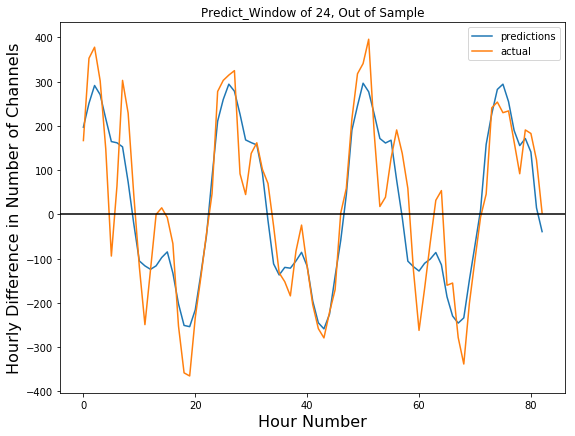

In [366]:
plot_lstm(day_test_predictions,day_test_actuals,
          'Predict_Window of 24, Out of Sample',
          'Hour Number',
          'Hourly Difference in Number of Channels',
         lower_lim_index=0)

In [314]:

# Parameters for predict window of 1

train_perc = 0.40
# How many points to look back - 168 = 24 hours/day * 7 days / week 
lags = 168
look_back = 24       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 168

# Neural net parameters
lstm_neurons = 128
# List of integers, each corresponding to the number of neurons in N dense layers,
# where N is the number of integers
dense_layers = []
epochs= 1000
batch_size = 10

In [278]:
week_prediction_model,\
week_prediction_dataset,\
week_prediction_train_X,\
week_prediction_train_Y,\
week_predictions,\
week_actuals = \
train_lstm(train_sample,['diff_channels'],lags, look_back,predict_window,lstm_neurons,dense_layers,epochs,batch_size)

Epoch 1/1000
294/294 [==============================] - 8s 27ms/step - loss: 40059.8743
Epoch 2/1000
294/294 [==============================] - 2s 7ms/step - loss: 39850.1194
Epoch 3/1000
294/294 [==============================] - 2s 7ms/step - loss: 39627.2617
Epoch 4/1000
294/294 [==============================] - 2s 7ms/step - loss: 39378.7961
Epoch 5/1000
294/294 [==============================] - 2s 7ms/step - loss: 39139.4082
Epoch 6/1000
294/294 [==============================] - 2s 7ms/step - loss: 38901.0387
Epoch 7/1000
294/294 [==============================] - 2s 7ms/step - loss: 38647.0750
Epoch 8/1000
294/294 [==============================] - 2s 7ms/step - loss: 38410.8154
Epoch 9/1000
294/294 [==============================] - 2s 7ms/step - loss: 38183.0418
Epoch 10/1000
294/294 [==============================] - 2s 7ms/step - loss: 37946.3474
Epoch 11/1000
294/294 [==============================] - 2s 7ms/step - loss: 37720.9704
Epoch 12/1000
294/294 [=================

294/294 [==============================] - 2s 6ms/step - loss: 24166.5342
Epoch 95/1000
294/294 [==============================] - 2s 6ms/step - loss: 24061.9310
Epoch 96/1000
294/294 [==============================] - 2s 6ms/step - loss: 23969.8843
Epoch 97/1000
294/294 [==============================] - 2s 6ms/step - loss: 23884.7724
Epoch 98/1000
294/294 [==============================] - 2s 6ms/step - loss: 23714.6923
Epoch 99/1000
294/294 [==============================] - 2s 7ms/step - loss: 23572.0589
Epoch 100/1000
294/294 [==============================] - 2s 7ms/step - loss: 23406.2758
Epoch 101/1000
294/294 [==============================] - 2s 7ms/step - loss: 23437.7799
Epoch 102/1000
294/294 [==============================] - 2s 7ms/step - loss: 23218.0210
Epoch 103/1000
294/294 [==============================] - 2s 7ms/step - loss: 23159.4521
Epoch 104/1000
294/294 [==============================] - 2s 7ms/step - loss: 22987.6442
Epoch 105/1000
294/294 [=================

294/294 [==============================] - 2s 7ms/step - loss: 16091.4210
Epoch 187/1000
294/294 [==============================] - 2s 7ms/step - loss: 15962.8090
Epoch 188/1000
294/294 [==============================] - 2s 7ms/step - loss: 15847.7072
Epoch 189/1000
294/294 [==============================] - 2s 7ms/step - loss: 16005.8923
Epoch 190/1000
294/294 [==============================] - 2s 7ms/step - loss: 15701.2904
Epoch 191/1000
294/294 [==============================] - 2s 7ms/step - loss: 15657.7135
Epoch 192/1000
294/294 [==============================] - 2s 7ms/step - loss: 15718.1787
Epoch 193/1000
294/294 [==============================] - 2s 6ms/step - loss: 15601.1676
Epoch 194/1000
294/294 [==============================] - 2s 7ms/step - loss: 15636.8860
Epoch 195/1000
294/294 [==============================] - 2s 7ms/step - loss: 15541.5848
Epoch 196/1000
294/294 [==============================] - 2s 7ms/step - loss: 15356.2751
Epoch 197/1000
294/294 [============

294/294 [==============================] - 2s 6ms/step - loss: 11999.0312
Epoch 279/1000
294/294 [==============================] - 2s 7ms/step - loss: 11960.5313
Epoch 280/1000
294/294 [==============================] - 2s 7ms/step - loss: 12028.6527
Epoch 281/1000
294/294 [==============================] - 2s 7ms/step - loss: 11901.4724
Epoch 282/1000
294/294 [==============================] - 2s 7ms/step - loss: 11818.4898
Epoch 283/1000
294/294 [==============================] - 2s 7ms/step - loss: 11829.1566
Epoch 284/1000
294/294 [==============================] - 2s 7ms/step - loss: 11855.3458
Epoch 285/1000
294/294 [==============================] - 2s 7ms/step - loss: 11802.5784
Epoch 286/1000
294/294 [==============================] - 2s 7ms/step - loss: 11777.2067
Epoch 287/1000
294/294 [==============================] - 2s 7ms/step - loss: 11705.3620
Epoch 288/1000
294/294 [==============================] - 2s 7ms/step - loss: 11630.0868
Epoch 289/1000
294/294 [============

294/294 [==============================] - 2s 7ms/step - loss: 9853.8475
Epoch 371/1000
294/294 [==============================] - 2s 7ms/step - loss: 10027.0430
Epoch 372/1000
294/294 [==============================] - 2s 7ms/step - loss: 9928.3082
Epoch 373/1000
294/294 [==============================] - 2s 7ms/step - loss: 9842.6860
Epoch 374/1000
294/294 [==============================] - 2s 7ms/step - loss: 9874.9199
Epoch 375/1000
294/294 [==============================] - 2s 7ms/step - loss: 9947.1384
Epoch 376/1000
294/294 [==============================] - 2s 7ms/step - loss: 9868.6353
Epoch 377/1000
294/294 [==============================] - 2s 6ms/step - loss: 9821.3759
Epoch 378/1000
294/294 [==============================] - 2s 7ms/step - loss: 9853.5817
Epoch 379/1000
294/294 [==============================] - 2s 7ms/step - loss: 9834.3067
Epoch 380/1000
294/294 [==============================] - 2s 7ms/step - loss: 9733.3941
Epoch 381/1000
294/294 [======================

294/294 [==============================] - 2s 7ms/step - loss: 8684.7340
Epoch 464/1000
294/294 [==============================] - 2s 7ms/step - loss: 8713.9318
Epoch 465/1000
294/294 [==============================] - 2s 7ms/step - loss: 8783.6161
Epoch 466/1000
294/294 [==============================] - 2s 7ms/step - loss: 8749.4051
Epoch 467/1000
294/294 [==============================] - 2s 7ms/step - loss: 8688.3934
Epoch 468/1000
294/294 [==============================] - 2s 7ms/step - loss: 8647.8120
Epoch 469/1000
294/294 [==============================] - 2s 7ms/step - loss: 8799.0724
Epoch 470/1000
294/294 [==============================] - 2s 7ms/step - loss: 8680.7399
Epoch 471/1000
294/294 [==============================] - 2s 7ms/step - loss: 8771.0665
Epoch 472/1000
294/294 [==============================] - 2s 7ms/step - loss: 8729.3452
Epoch 473/1000
294/294 [==============================] - 2s 7ms/step - loss: 8640.8642
Epoch 474/1000
294/294 [=======================

294/294 [==============================] - 2s 7ms/step - loss: 8039.2941
Epoch 557/1000
294/294 [==============================] - 2s 6ms/step - loss: 7958.3932
Epoch 558/1000
294/294 [==============================] - 2s 7ms/step - loss: 8030.7694
Epoch 559/1000
294/294 [==============================] - 2s 7ms/step - loss: 8006.7248
Epoch 560/1000
294/294 [==============================] - 2s 7ms/step - loss: 7976.6474
Epoch 561/1000
294/294 [==============================] - 2s 7ms/step - loss: 8042.7724
Epoch 562/1000
294/294 [==============================] - 2s 7ms/step - loss: 7949.6594
Epoch 563/1000
294/294 [==============================] - 2s 7ms/step - loss: 7966.5751
Epoch 564/1000
294/294 [==============================] - 2s 7ms/step - loss: 7914.1062
Epoch 565/1000
294/294 [==============================] - 2s 7ms/step - loss: 7850.8490
Epoch 566/1000
294/294 [==============================] - 2s 7ms/step - loss: 7991.1994
Epoch 567/1000
294/294 [=======================

294/294 [==============================] - 2s 7ms/step - loss: 7479.9358
Epoch 650/1000
294/294 [==============================] - 2s 7ms/step - loss: 7421.1195
Epoch 651/1000
294/294 [==============================] - 2s 6ms/step - loss: 7453.7561
Epoch 652/1000
294/294 [==============================] - 2s 7ms/step - loss: 7511.6940
Epoch 653/1000
294/294 [==============================] - 2s 7ms/step - loss: 7395.1030
Epoch 654/1000
294/294 [==============================] - 2s 7ms/step - loss: 7465.8255
Epoch 655/1000
294/294 [==============================] - 2s 7ms/step - loss: 7457.7399
Epoch 656/1000
294/294 [==============================] - 2s 7ms/step - loss: 7409.9089
Epoch 657/1000
294/294 [==============================] - 2s 6ms/step - loss: 7368.4165
Epoch 658/1000
294/294 [==============================] - 2s 6ms/step - loss: 7442.6714
Epoch 659/1000
294/294 [==============================] - 2s 7ms/step - loss: 7352.6854
Epoch 660/1000
294/294 [=======================

294/294 [==============================] - 2s 6ms/step - loss: 7198.6118
Epoch 743/1000
294/294 [==============================] - 2s 6ms/step - loss: 7092.5050
Epoch 744/1000
294/294 [==============================] - 2s 6ms/step - loss: 7114.1599
Epoch 745/1000
294/294 [==============================] - 2s 6ms/step - loss: 7099.3118
Epoch 746/1000
294/294 [==============================] - 2s 7ms/step - loss: 7002.7408
Epoch 747/1000
294/294 [==============================] - 2s 6ms/step - loss: 7147.4891
Epoch 748/1000
294/294 [==============================] - 2s 6ms/step - loss: 7105.8572
Epoch 749/1000
294/294 [==============================] - 2s 6ms/step - loss: 6930.8538
Epoch 750/1000
294/294 [==============================] - 2s 6ms/step - loss: 7032.1198
Epoch 751/1000
294/294 [==============================] - 2s 6ms/step - loss: 7009.1971
Epoch 752/1000
294/294 [==============================] - 2s 6ms/step - loss: 7083.7924
Epoch 753/1000
294/294 [=======================

294/294 [==============================] - 2s 6ms/step - loss: 6681.1474
Epoch 836/1000
294/294 [==============================] - 2s 6ms/step - loss: 6750.9319
Epoch 837/1000
294/294 [==============================] - 2s 6ms/step - loss: 6775.1808
Epoch 838/1000
294/294 [==============================] - 2s 6ms/step - loss: 6747.1673
Epoch 839/1000
294/294 [==============================] - 2s 6ms/step - loss: 6830.2962
Epoch 840/1000
294/294 [==============================] - 2s 6ms/step - loss: 6750.6088
Epoch 841/1000
294/294 [==============================] - 2s 6ms/step - loss: 6770.1923
Epoch 842/1000
294/294 [==============================] - 2s 6ms/step - loss: 6828.4871
Epoch 843/1000
294/294 [==============================] - 2s 6ms/step - loss: 6663.7846
Epoch 844/1000
294/294 [==============================] - 2s 6ms/step - loss: 6772.6943
Epoch 845/1000
294/294 [==============================] - 2s 6ms/step - loss: 6681.2500
Epoch 846/1000
294/294 [=======================

294/294 [==============================] - 2s 6ms/step - loss: 6814.8255
Epoch 929/1000
294/294 [==============================] - 2s 6ms/step - loss: 6731.1248
Epoch 930/1000
294/294 [==============================] - 2s 6ms/step - loss: 6614.9906
Epoch 931/1000
294/294 [==============================] - 2s 6ms/step - loss: 6688.8116
Epoch 932/1000
294/294 [==============================] - 2s 6ms/step - loss: 6625.1397
Epoch 933/1000
294/294 [==============================] - 2s 6ms/step - loss: 6603.0414
Epoch 934/1000
294/294 [==============================] - 2s 6ms/step - loss: 6617.0830
Epoch 935/1000
294/294 [==============================] - 2s 6ms/step - loss: 6574.0326
Epoch 936/1000
294/294 [==============================] - 2s 6ms/step - loss: 6651.2914
Epoch 937/1000
294/294 [==============================] - 2s 6ms/step - loss: 6482.3672
Epoch 938/1000
294/294 [==============================] - 2s 7ms/step - loss: 6584.2916
Epoch 939/1000
294/294 [=======================

In [346]:
week_test_predictions, week_test_actuals =\
test_lstm(test_sample,['diff_channels'], week_prediction_model, predict_window)

Lenght of dataset:  394
Stop value(len(dataset) - lags - predict_window:  58
Start value: look_back:  24


In [353]:
week_true_test_predictions, week_true_test_actuals =\
test_lstm(true_test_sample,['diff_channels'], week_prediction_model, predict_window)

Lenght of dataset:  168
Stop value(len(dataset) - lags - predict_window:  -168
Start value: look_back:  24


ValueError: negative dimensions are not allowed

In [350]:
rmse(week_test_predictions,week_test_actuals)

80.89213998671967

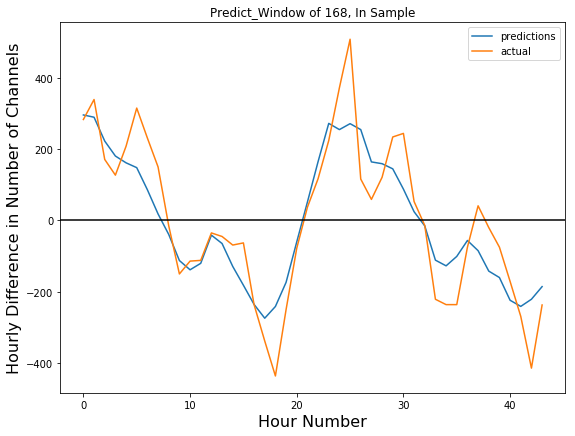

Not Saved


In [387]:
plot_lstm(week_predictions,week_actuals,
          'Predict_Window of 168, In Sample',
          'Hour Number',
          'Hourly Difference in Number of Channels',
         lower_lim_index=250)

In [295]:
# week_prediction_model.save('./week_prediction_lstm.mdl')

In [384]:
week_test_predictions

array([ 175.1618   ,  155.18544  ,  143.34654  ,  103.668655 ,
          0.5084823,  -50.7823   , -135.3054   , -120.20137  ,
       -113.97639  ,  -53.63328  ,  -98.712555 , -153.65588  ,
       -168.84377  , -241.58072  , -252.40776  , -228.87587  ,
       -221.91977  , -126.08404  ,   13.46688  ,  137.91731  ,
        224.52544  ,  308.8101   ,  303.54147  ,  224.80933  ,
        174.8482   ,  155.66533  ,  147.07971  ,  107.72327  ,
         42.49489  ,  -45.471283 , -120.95389  , -125.80205  ,
       -120.189316 ,  -57.695026 ], dtype=float32)

In [361]:
week_test_actuals

array([  61.,  106.,  247.,  199.,  -63., -122., -226., -122.,  -68.,
        -29.,  -14., -182., -241., -336., -230., -254., -165.,  -31.,
         13.,  273.,  442.,  331.,  291.,   66.,   56.,  147.,  204.,
        179.,   19., -135., -211., -104., -115.,  -35.])

In [382]:
len(week_test_actuals)

34

saved to : ./graphs/lstm_out_of_sample.png


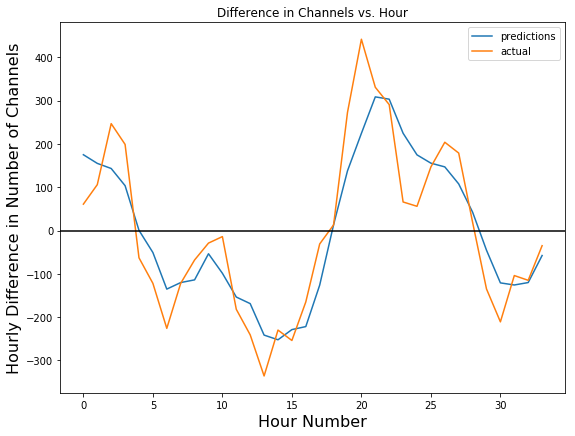

In [407]:
plot_lstm(week_test_predictions,week_test_actuals,
          'Difference in Channels vs. Hour',
          'Hour Number',
          'Hourly Difference in Number of Channels',
         lower_lim_index=0,saved_fig_name='lstm_out_of_sample.png')

In [350]:
rmse(week_test_predictions,week_test_actuals)

80.89213998671967

In [351]:
rmse(week_predictions,week_actuals)

81.71352857661121

In [ ]:
rmse(week_pre)